In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

# To display the float values upto 6 decimal places     
pd.options.display.float_format = '{:.6f}'.format

import statsmodels
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse

from scipy import stats
from scipy.stats import shapiro

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

#### Reading and Understanding the data

In [2]:
df = pd.read_csv('Emp_reimb.csv')
df.head()

,Year,Type_of_yr,Emp_ID,Income,Other_Income,Overtime,Total_Income,Health_Insurance,Retirement,Other_Benefits,Total_Benefits,Total_Reimbursement
0,2015,Financial,42865,92288.220000,267.450000,270.450000,92826.120000,12500.560000,20703.200000,7605.750000,40809.510000,133635.630000
1,2015,Calendar,28253,1466.380000,0.000000,350.230000,1816.610000,442.030000,3.000000,141.590000,586.620000,2403.230000
2,2018,Financial,30664,76536.950000,10855.940000,13586.720000,100979.610000,12464.610000,18636.190000,8011.410000,39112.210000,140091.820000
3,2018,Financial,19482,45659.880000,1625.370000,3.000000,47288.250000,0.000000,10084.200000,3936.630000,14020.830000,61309.080000
4,2017,Financial,7183,41832.000000,0.000000,6.000000,41838.000000,5908.520000,7621.600000,3254.500000,16784.620000,58622.620000


In [3]:
df.shape

(49794, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49794 entries, 0 to 49793
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 49794 non-null  int64  
 1   Type_of_yr           49794 non-null  object 
 2   Emp_ID               49794 non-null  int64  
 3   Income               49794 non-null  float64
 4   Other_Income         49794 non-null  float64
 5   Overtime             49794 non-null  float64
 6   Total_Income         49794 non-null  float64
 7   Health_Insurance     49794 non-null  float64
 8   Retirement           49794 non-null  float64
 9   Other_Benefits       49794 non-null  float64
 10  Total_Benefits       49794 non-null  float64
 11  Total_Reimbursement  49794 non-null  float64
dtypes: float64(9), int64(2), object(1)
memory usage: 4.6+ MB


From the above info, we see that "Type_of_yr" is only categorical and the other variables are numerical.

As per the data definition, "Year" is of categorical data type but here it got iterpreted as int64. Therefore, this will be converted to 'object' datatype. 

In [5]:
df['Year'] = df['Year'].astype('object')

In [6]:
df.dtypes

Year                    object
Type_of_yr              object
Emp_ID                   int64
Income                 float64
Other_Income           float64
Overtime               float64
Total_Income           float64
Health_Insurance       float64
Retirement             float64
Other_Benefits         float64
Total_Benefits         float64
Total_Reimbursement    float64
dtype: object

#### Remove insignificant variables

The variable Emp_ID has the details of employee ID numbers and hence it doesn't serve much use for further analysis. 

In [7]:
df = df.drop('Emp_ID', axis = 1)
df.head(3)

,Year,Type_of_yr,Income,Other_Income,Overtime,Total_Income,Health_Insurance,Retirement,Other_Benefits,Total_Benefits,Total_Reimbursement
0,2015,Financial,92288.220000,267.450000,270.450000,92826.120000,12500.560000,20703.200000,7605.750000,40809.510000,133635.630000
1,2015,Calendar,1466.380000,0.000000,350.230000,1816.610000,442.030000,3.000000,141.590000,586.620000,2403.230000
2,2018,Financial,76536.950000,10855.940000,13586.720000,100979.610000,12464.610000,18636.190000,8011.410000,39112.210000,140091.820000


#### Outlier Treatment and Analysis

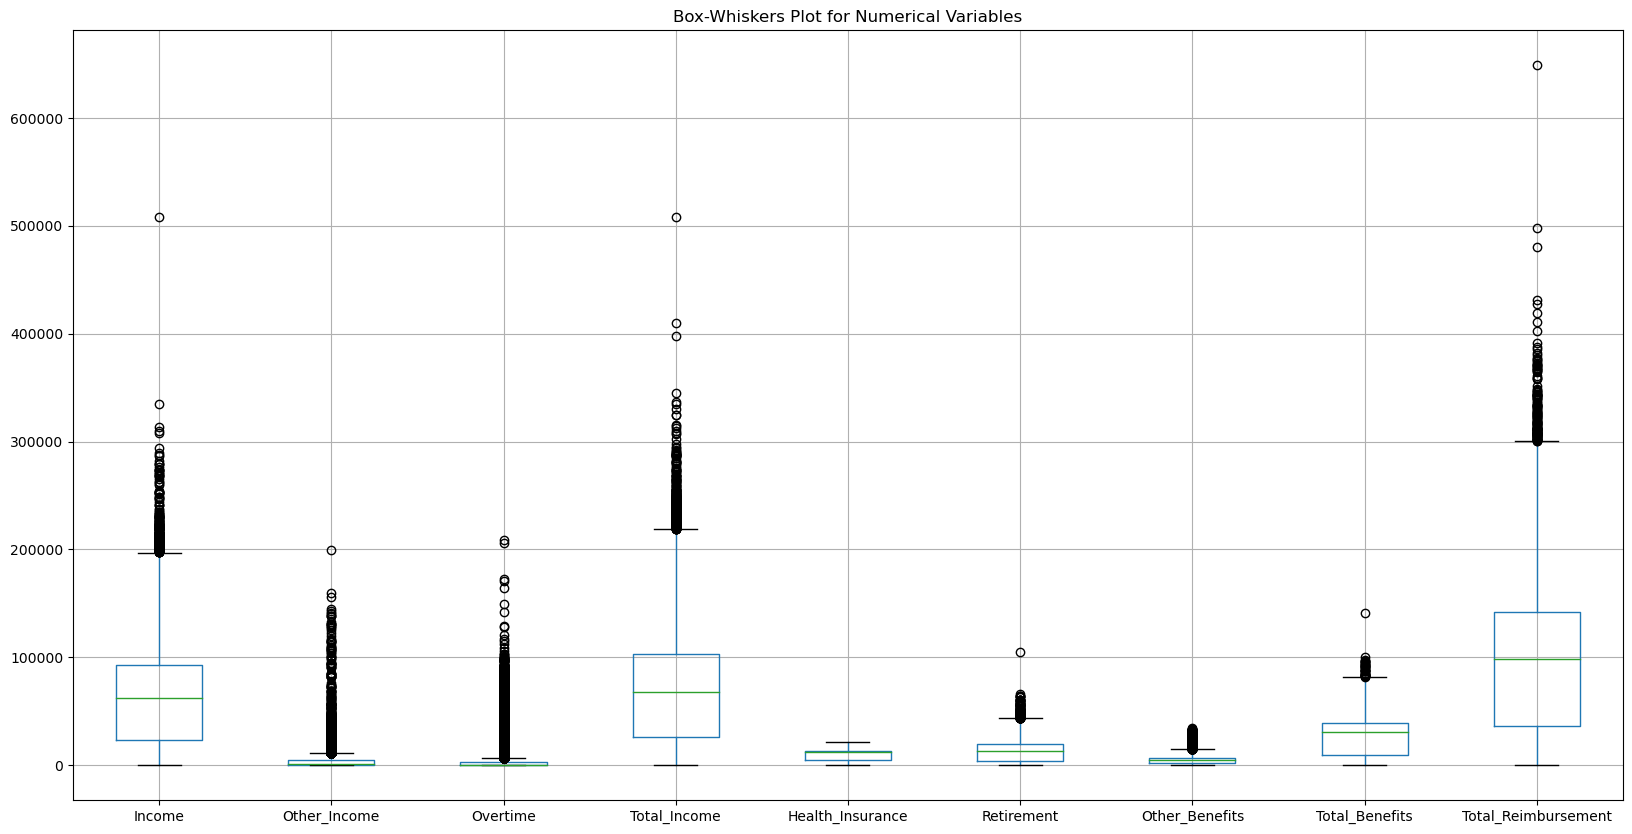

In [8]:
plt.figure(figsize = (20,10))
df.boxplot()
plt.title("Box-Whiskers Plot for Numerical Variables")
plt.xticks()
plt.show()

The variables Income, Total_income and Total_Reimbursement have a larger range of values as compared to other variables. Let's visualize the other variables once more without the former three to obtain the distribution of the later.

In [9]:
df.columns

Index(['Year', 'Type_of_yr', 'Income', 'Other_Income', 'Overtime',
       'Total_Income', 'Health_Insurance', 'Retirement', 'Other_Benefits',
       'Total_Benefits', 'Total_Reimbursement'],
      dtype='object')

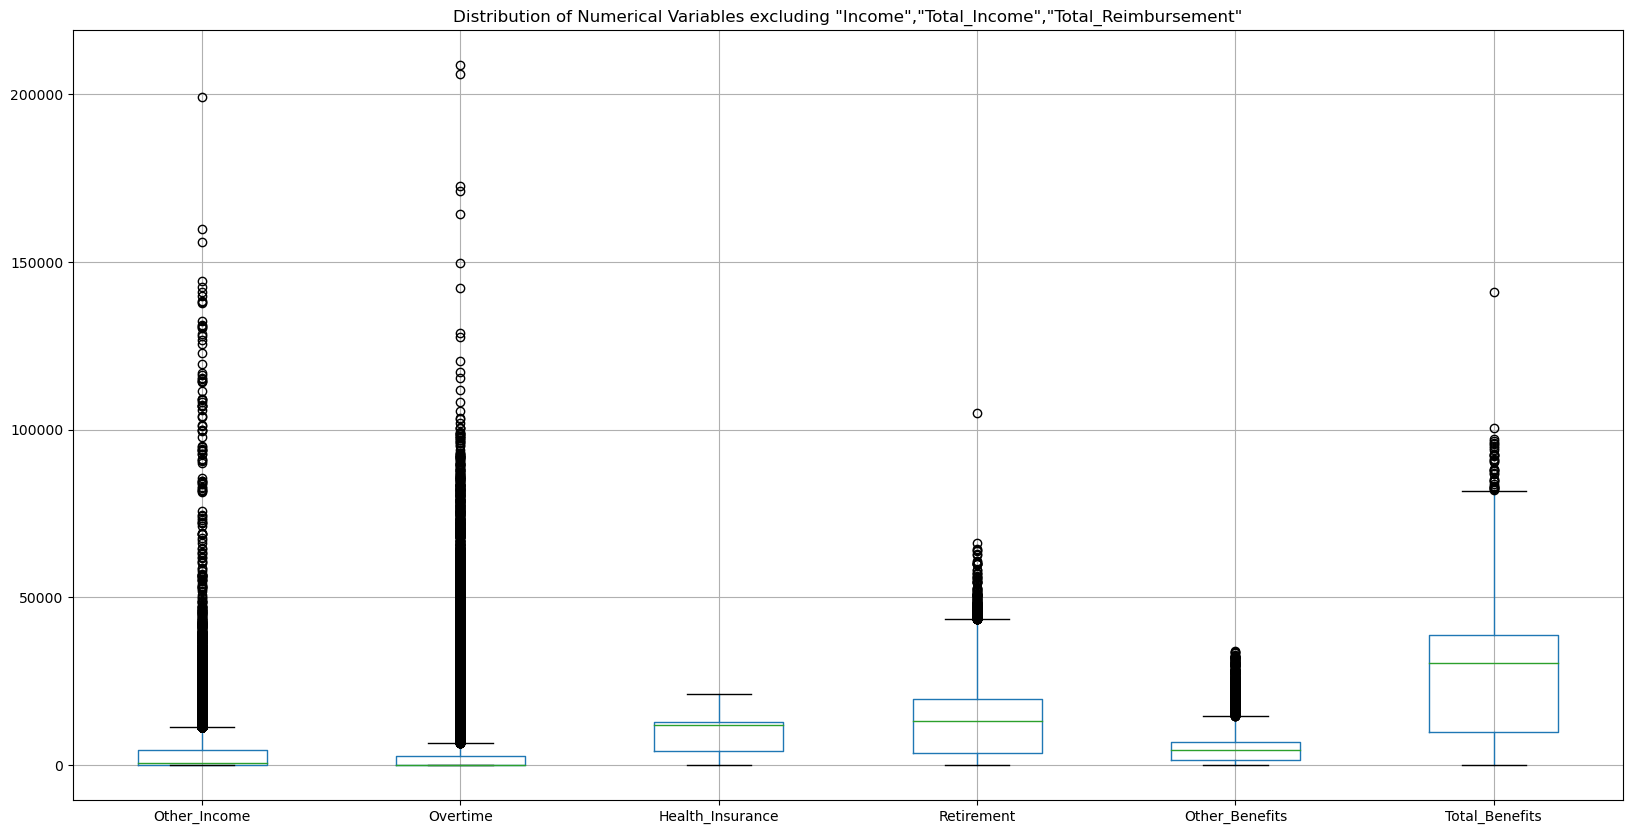

In [10]:
plt.figure(figsize = (20,10))
df.loc[:,['Other_Income', 'Overtime', 'Health_Insurance', 'Retirement', 'Other_Benefits', 'Total_Benefits']].boxplot()
plt.title('Distribution of Numerical Variables excluding "Income","Total_Income","Total_Reimbursement"')
plt.xticks()
plt.show()

Therefore, all variables except "Health_Insurance" have outliers. 

In [11]:
numeric_cols = list(df.dtypes[df.dtypes=='float64'].index)

In [12]:
# first quartile
q1 = df[numeric_cols].quantile(0.25)

# Third quantile
q3 = df[numeric_cols].quantile(0.75)

IQR = q3 - q1

df = df[~((df[numeric_cols] < (q1-1.5*IQR)) | (df[numeric_cols] > (q3+1.5*IQR))).any(axis=1)]
df.shape

(37601, 11)

#### Missing Values Analysis and Treatment

In [13]:
df.isnull().sum()

Year                   0
Type_of_yr             0
Income                 0
Other_Income           0
Overtime               0
Total_Income           0
Health_Insurance       0
Retirement             0
Other_Benefits         0
Total_Benefits         0
Total_Reimbursement    0
dtype: int64

There are no missing values

#### Scale Data

In [14]:
scale = StandardScaler()

In [15]:
df.iloc[:,2:] = scale.fit_transform(df.iloc[:,2:])

In [16]:
df

,Year,Type_of_yr,Income,Other_Income,Overtime,Total_Income,Health_Insurance,Retirement,Other_Benefits,Total_Benefits,Total_Reimbursement
0,2015,Financial,0.979285,-0.476490,-0.234452,0.921936,0.911633,1.173979,1.141809,1.156404,0.996741
1,2015,Calendar,-1.259498,-0.588288,-0.175596,-1.270543,-1.504323,-1.186991,-1.269397,-1.374579,-1.312368
3,2018,Financial,-0.170116,0.091141,-0.431758,-0.175101,-1.592885,-0.037175,-0.043455,-0.529245,-0.275886
4,2017,Financial,-0.264475,-0.588288,-0.429544,-0.306401,-0.409098,-0.318048,-0.263809,-0.355337,-0.323156
5,2017,Calendar,0.531729,0.015084,-0.431020,0.506452,0.989326,0.506986,0.698634,0.726502,0.573061
...,...,...,...,...,...,...,...,...,...,...,...
49788,2015,Calendar,-1.032798,-0.560728,-0.430282,-1.055717,-0.961290,-1.186991,-1.031131,-1.157619,-1.094793
49790,2018,Financial,-1.251584,-0.588288,-0.428069,-1.271053,-1.480024,-1.186991,-1.268179,-1.366710,-1.310541
49791,2016,Financial,-0.394608,-0.588288,-0.430282,-0.433604,-0.219302,-0.411017,-0.322883,-0.358526,-0.416955
49792,2016,Financial,-0.137198,3.986109,-0.430282,0.081590,0.535788,-0.178629,0.205200,0.109694,0.090266


In [17]:
pd.DataFrame([np.round(df.iloc[:,2:].mean()),np.round(df.iloc[:,2:].std())],index=['Mean','Standard Deviation'])

,Income,Other_Income,Overtime,Total_Income,Health_Insurance,Retirement,Other_Benefits,Total_Benefits,Total_Reimbursement
Mean,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
Standard Deviation,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As we can see above the mean is 0 and standard deviation is 1 which goes along with the standard normal distribution property of mean = 0 and standard deviation 1.

### Build MLR Model

In [18]:
df_ind = df.drop("Total_Reimbursement", axis = 1)
df_dep = df["Total_Reimbursement"]

xc = sm.add_constant(df_ind)

In [19]:
xc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37601 entries, 0 to 49793
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   const             37601 non-null  float64
 1   Year              37601 non-null  object 
 2   Type_of_yr        37601 non-null  object 
 3   Income            37601 non-null  float64
 4   Other_Income      37601 non-null  float64
 5   Overtime          37601 non-null  float64
 6   Total_Income      37601 non-null  float64
 7   Health_Insurance  37601 non-null  float64
 8   Retirement        37601 non-null  float64
 9   Other_Benefits    37601 non-null  float64
 10  Total_Benefits    37601 non-null  float64
dtypes: float64(9), object(2)
memory usage: 3.4+ MB


In [20]:
base_model = sm.OLS(df_dep, xc.select_dtypes(np.number)).fit()
print(base_model.summary())

                             OLS Regression Results                            
Dep. Variable:     Total_Reimbursement   R-squared:                       1.000
Model:                             OLS   Adj. R-squared:                  1.000
Method:                  Least Squares   F-statistic:                 3.151e+34
Date:                 Mon, 10 Feb 2025   Prob (F-statistic):               0.00
Time:                         23:46:02   Log-Likelihood:             1.2757e+06
No. Observations:                37601   AIC:                        -2.551e+06
Df Residuals:                    37594   BIC:                        -2.551e+06
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -3.078e-17   

**Inference:** The R-Squared obtained here is 1 and this means the model explains 100% variation in the target variable which is not possible and is clear situation of overfitting.

Let's check on some assumptions related to linear regression:

**Autocorrelation**


Durbin-Watson value is 1.977 which is close to 2. Hence, **No Autocorrelation**.

**Linear Relationship**

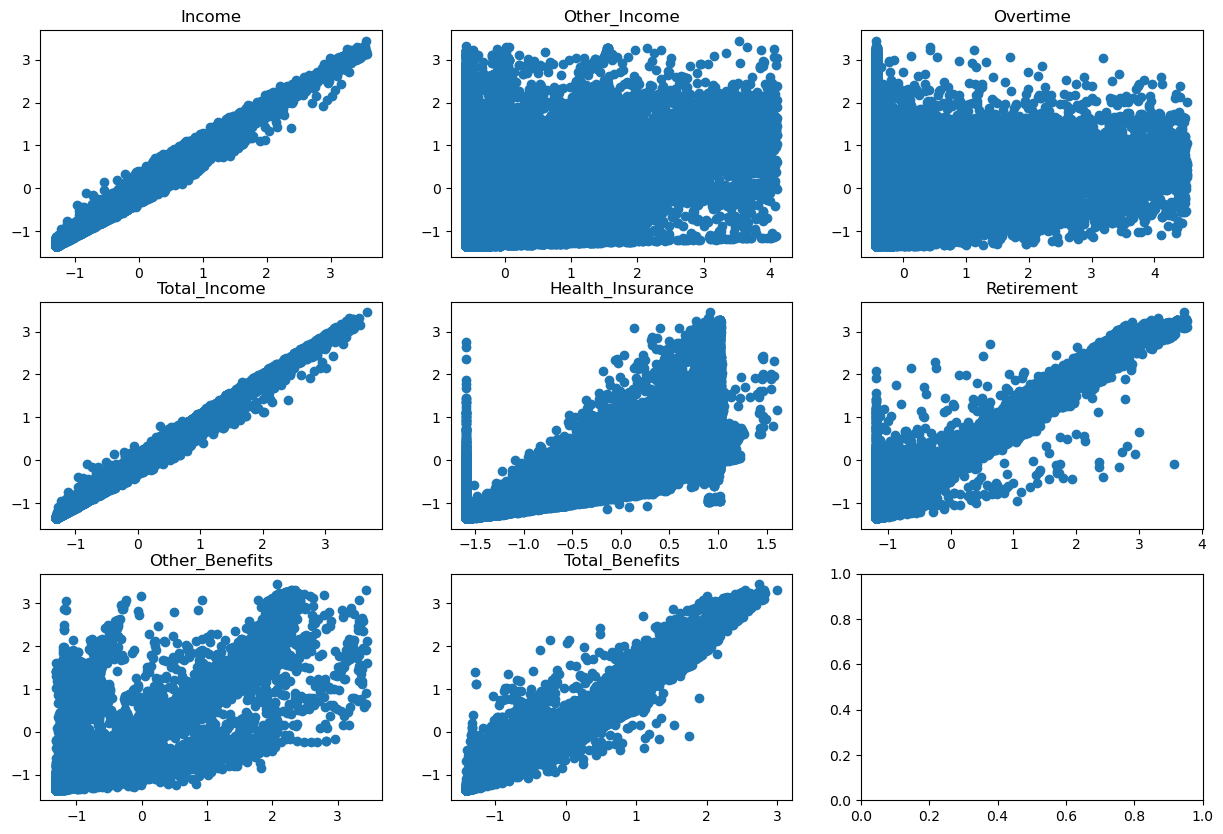

In [21]:
plt.rcParams["figure.figsize"] = (15,10)
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3)
ax1.scatter(df['Income'],df_dep)
ax1.set_title('Income')

ax2.scatter(df['Other_Income'],df_dep)
ax2.set_title('Other_Income')

ax3.scatter(df['Overtime'],df_dep)
ax3.set_title('Overtime')

ax4.scatter(df['Total_Income'],df_dep)
ax4.set_title('Total_Income')

ax5.scatter(df['Health_Insurance'],df_dep)
ax5.set_title('Health_Insurance')

ax6.scatter(df['Retirement'],df_dep)
ax6.set_title('Retirement')

# ax7 = fig.get_axes()[6] # Access the 7th subplot (index starts from 0)
ax7.scatter(df['Other_Benefits'],df_dep)
ax7.set_title('Other_Benefits')
# plt.show()

ax8 = fig.get_axes()[7] # Access the 8th subplot (index starts from 0)
ax8.scatter(df['Total_Benefits'],df_dep)
ax8.set_title('Total_Benefits')
plt.show()

All the above variables possess some amount of linearity. However, further testing is required for 'Other_Income' and 'Overtime'.

**Multicollinearity**

If CN < 100: No Multicollinearity

If CN is between 100 and 1000: Moderate Multicollinearity

If CN > 1000: High Multicollinearity

In [22]:
print("Condition Number:",base_model.condition_number)

Condition Number: 6848171030317194.0


Based on the condition number obtained, we can say there exists severe multicollinearity in this data.

Indeed, VIF (Variance Inflation Factor) can be used to diagnose multicollinearity in this model.

In [23]:
vif_df = pd.DataFrame(columns = ["Variable","VIF"])
for i in range(df_ind.select_dtypes(include = np.number).shape[1]):
    var_nm = df_ind.select_dtypes(include = np.number).columns[i]
    vif_val = variance_inflation_factor(df_ind.select_dtypes(include = np.number).values,i)
    temp_df = pd.DataFrame([[var_nm, vif_val]], columns = ["Variable", "VIF"])
    vif_df = pd.concat([vif_df,temp_df])
    
vif_df.reset_index(drop = True, inplace = True)
vif_df

,Variable,VIF
0,Income,inf
1,Other_Income,inf
2,Overtime,inf
3,Total_Income,inf
4,Health_Insurance,inf
5,Retirement,inf
6,Other_Benefits,inf
7,Total_Benefits,inf


As, VIF values show up "inf", we need to sort, remove and check the VIF iteratively.

**Homoscedasticity - Constant Variance**

Presence of Homoscedasticity tells us that the residuals is consistent across all the independent variables.

In [24]:
sm.stats.diagnostic.het_goldfeldquandt(y = df_dep,x = df_ind.select_dtypes(include = np.number))

(0.3427316287888704, 0.9999999999999999, 'increasing')

In [25]:
f_val,p_val,ordering = sm.stats.diagnostic.het_goldfeldquandt(y = df_dep,x = df_ind.select_dtypes(include = np.number))

In [26]:
print(p_val)

0.9999999999999999


In [27]:
# Ho: Variance is same among sub-samples/Variance is constant across the range of data.
# H1: Variance is NOT constant across range of data.

The p-value is 0.99 which is more than 0.05 therefore we fail to reject null hypothesis. Thus the variance is same across the data satisfying this assumption.

**Residuals are normally distributed**

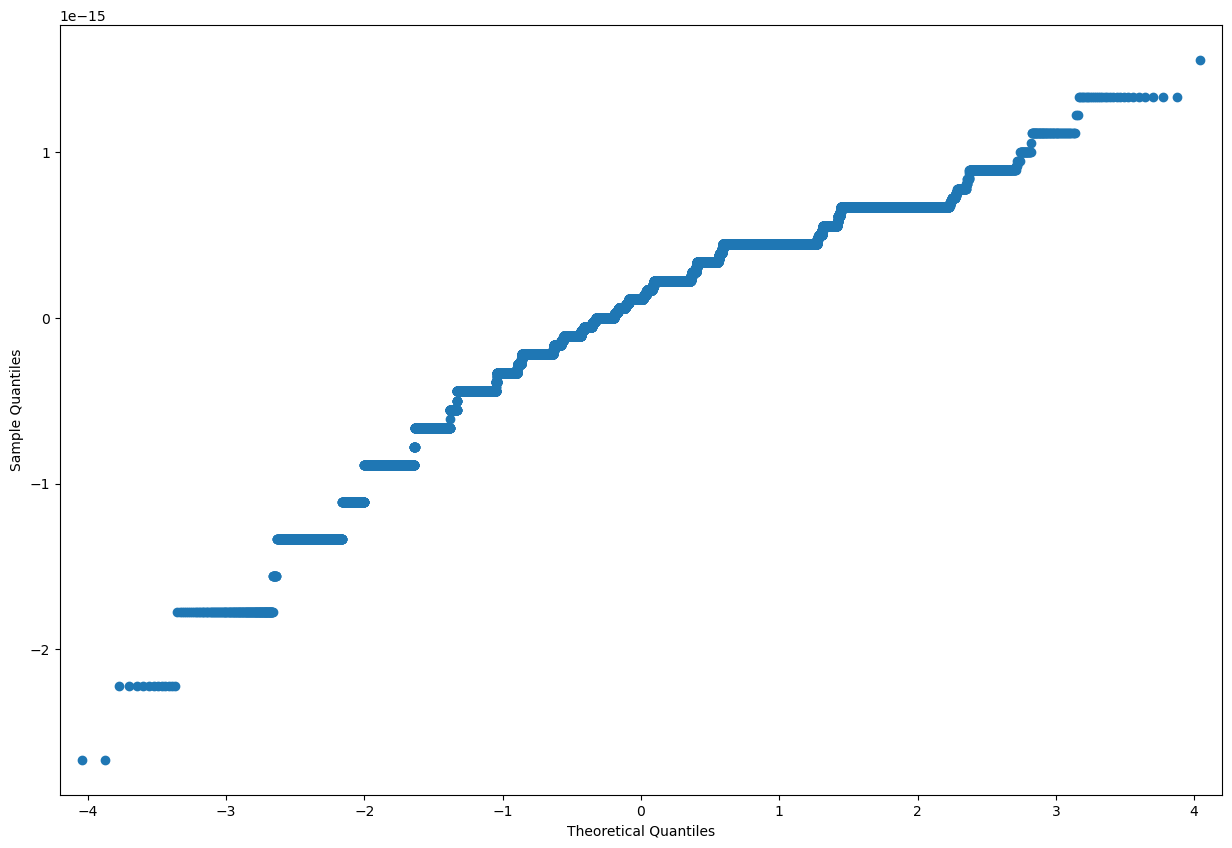

In [28]:
sm.qqplot(base_model.resid)
plt.show()

In [29]:
# Jarque-Bera Test
# Ho: Residuals are normally distributed
# H1: Residuals are not normally distributed

Since, P-Value is less than 0.05, we reject null hypothesis. Therefore, Residuals are not normally distributed violating this assumption.

**No Endogeneity**

This assumption checks if there is linear relationship between errors and independent variables.

In [30]:
# Ho: Fit of model using full sample = Fit of model using central subset (Linear Relationship).
# H1: Fit of model using full sample is worse compared to fit of model using central subset.

In [31]:
f_stat,p_val = sm.stats.diagnostic.linear_rainbow(base_model)
print("P-Value",p_val)

P-Value 0.0


As, p-value is less than 0.05. We reject the null hypothesis and thereby conclude the fit of model using full sample is worse compared to the fit of model using central subset. This assumption is not satisfied.

**Using VIF to remove variables with high multicollinearity**

In [32]:
for ind_var in range(len(df_ind.select_dtypes(include = np.number).columns)):
    vif = pd.DataFrame()
    
    vif["vif_factor"] = [variance_inflation_factor(df_ind.select_dtypes(include = np.number).values,i) for i in range(df_ind.select_dtypes(include = np.number).shape[1])]
    
    vif["Features"] = df_ind.select_dtypes(include = np.number).columns
    
    multi = vif[vif["vif_factor"]>10]
    
    if multi.empty==False:
        df_sorted = multi.sort_values(by = "vif_factor", ascending  = False)
    else:
        print(vif)
        break
    
    if df_sorted.empty==False:
        df_ind =  df_ind.drop(df_sorted.Features.iloc[0], axis = 1)
    else:
        print(vif)
    

   vif_factor        Features
0    1.176818    Other_Income
1    1.107197        Overtime
2    3.914703      Retirement
3    3.699482  Other_Benefits


We have now obtained all the variables with  VIF less than 10 and therefore we can conclude that there isn't high level of multicollinearity present in the data affectig the model building process. Let's use the significant variables obtained above to build MLR model.

**MLR Model after removing insignificant variables**

In [33]:
df_num = df_ind.select_dtypes(include = np.number)

In [34]:
df_cat = df_ind.select_dtypes(include = "object")

In [35]:
df_cat_encoded = pd.get_dummies(data = df_cat, drop_first = True)

In [36]:
df_ind_signi = pd.concat([df_num,df_cat_encoded], axis = 1)
df_ind_signi.head()

,Other_Income,Overtime,Retirement,Other_Benefits,Year_2016,Year_2017,Year_2018,Type_of_yr_Financial
0,-0.476490,-0.234452,1.173979,1.141809,0,0,0,1
1,-0.588288,-0.175596,-1.186991,-1.269397,0,0,0,0
3,0.091141,-0.431758,-0.037175,-0.043455,0,0,1,1
4,-0.588288,-0.429544,-0.318048,-0.263809,0,1,0,1
5,0.015084,-0.431020,0.506986,0.698634,0,1,0,0


In [37]:
x_signi_var = df_ind_signi
y_var = df_dep

x_signi_var = sm.add_constant(x_signi_var)
x_signi_var.head()

,const,Other_Income,Overtime,Retirement,Other_Benefits,Year_2016,Year_2017,Year_2018,Type_of_yr_Financial
0,1.000000,-0.476490,-0.234452,1.173979,1.141809,0,0,0,1
1,1.000000,-0.588288,-0.175596,-1.186991,-1.269397,0,0,0,0
3,1.000000,0.091141,-0.431758,-0.037175,-0.043455,0,0,1,1
4,1.000000,-0.588288,-0.429544,-0.318048,-0.263809,0,1,0,1
5,1.000000,0.015084,-0.431020,0.506986,0.698634,0,1,0,0


In [38]:
x_train_signi,x_test_signi,y_train,y_test = train_test_split(x_signi_var, y_var, test_size = 0.3, random_state = 1)
print("X Train Shape:",x_train_signi.shape)
print("X Test Shape:",x_test_signi.shape)
print("Y Train Shape:",y_train.shape)
print("Y Test Shape:",y_test.shape)

X Train Shape: (26320, 9)
X Test Shape: (11281, 9)
Y Train Shape: (26320,)
Y Test Shape: (11281,)


In [39]:
MLR_Model_signi = sm.OLS(y_train, x_train_signi).fit()
print(MLR_Model_signi.summary())

                             OLS Regression Results                            
Dep. Variable:     Total_Reimbursement   R-squared:                       0.962
Model:                             OLS   Adj. R-squared:                  0.962
Method:                  Least Squares   F-statistic:                 8.218e+04
Date:                 Mon, 10 Feb 2025   Prob (F-statistic):               0.00
Time:                         23:46:04   Log-Likelihood:                 5494.7
No. Observations:                26320   AIC:                        -1.097e+04
Df Residuals:                    26311   BIC:                        -1.090e+04
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 

 **Inference:** The R-Squared value obtained from this model is 0.962 which means that the above model explains 96.2% of the variation in the Total_Reimbursement. Also, we can see the p-value for some variables is greater than 0.05, we remove such variables and again build the model. 

**Calculation of p-values to identify the insignificant variables**

In [40]:
MLR_model_signi_pvalues = pd.DataFrame(MLR_Model_signi.pvalues, columns = ["P-Value"])
MLR_model_signi_pvalues

,P-Value
const,0.000000
Other_Income,0.000000
Overtime,0.000000
Retirement,0.000000
Other_Benefits,0.000000
Year_2016,0.000000
Year_2017,0.000000
Year_2018,0.546668
Type_of_yr_Financial,0.475203


In [41]:
insignificant_var = MLR_model_signi_pvalues[1:][MLR_model_signi_pvalues[1:]["P-Value"] > 0.05]
print("Insignificant Variables:",insignificant_var.index.to_list())

Insignificant Variables: ['Year_2018', 'Type_of_yr_Financial']


Let's Drop 'Type_of_yr_Financial' as one categorical variable that is insignificant. We'll retain the variable 'Year_2018' as it is one out of the four categories that also has similar categories for different years.

In [42]:
x_train_signi.drop(['Type_of_yr_Financial'], axis = 1, inplace = True)
x_test_signi.drop(['Type_of_yr_Financial'], axis = 1, inplace = True)

In [43]:
# Building the model again on the training dataset
MLR_model_signi_1 = sm.OLS(y_train, x_train_signi).fit()
print(MLR_model_signi_1.summary())

                             OLS Regression Results                            
Dep. Variable:     Total_Reimbursement   R-squared:                       0.962
Model:                             OLS   Adj. R-squared:                  0.962
Method:                  Least Squares   F-statistic:                 9.392e+04
Date:                 Mon, 10 Feb 2025   Prob (F-statistic):               0.00
Time:                         23:46:04   Log-Likelihood:                 5494.4
No. Observations:                26320   AIC:                        -1.097e+04
Df Residuals:                    26312   BIC:                        -1.091e+04
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0444      0.0

**Inference:** The R-Squared value 0.962 tells us that the model explains 96.2% variation in the Total_Reimbursement.

Durbin Watson test is used to check autocorrelation between residuals.
Here, the Durbin-Watson test statistic is 1.965 i.e. 2(approx.). Hence, we can conclude that there is **no autocorrelation** between residuals.



Durbin-Watson Test Inference guide:
> Durbin-Watson test statistic is near to 2: No autocorrelation.

> Durbin-Watson test statistic is between 0 and 2: Positive autocorrelation.

> Durbin-Watson test statistic is between 2 and 4: Negative autocorrelation.

Jarque-Bera test is used to check the normality of residuals. Here, the p-value of Jarque-Bera test is less than 0.05. Hence, we reject null hypothesis thereby concluding that residuals are not normally distributed.

Cond. No. - Condition Number is used to check multicollinearity

If CN < 100 No Multicollinearity.

If CN is between 100 and 1000: Moderate Multicollinearity.

If CN > 1000: Severe Multicollinearity.

Here, the Cond. No. is less than 6.03. Therefore, there is no multicollinearity.

**Now, let's predict the Total_Reimbursement using X_test_signi_var**

In [44]:
y_test_pred_signi_var = MLR_model_signi_1.predict(x_test_signi)
y_test_pred_signi_var

41695    0.333985
76      -1.087138
38316   -1.165507
25510   -0.959778
6356    -1.002021
           ...   
37270    0.233848
7295     0.599475
9990     2.575039
23066   -0.385424
25924    1.630031
Length: 11281, dtype: float64

In [45]:
predicted_df = pd.DataFrame(y_test_pred_signi_var, columns = ["Predicted-Total_Reimbursement"])

final_act_pred_df = x_test_signi.join(y_test).join(predicted_df)
final_act_pred_df

,const,Other_Income,Overtime,Retirement,Other_Benefits,Year_2016,Year_2017,Year_2018,Total_Reimbursement,Predicted-Total_Reimbursement
41695,1.000000,2.865151,1.411466,0.526144,-0.889505,0,0,0,0.545572,0.333985
76,1.000000,0.262331,-0.429544,-1.147312,-1.215770,0,1,0,-1.274451,-1.087138
38316,1.000000,-0.512247,-0.431020,-1.186877,-0.806316,0,0,0,-0.881266,-1.165507
25510,1.000000,-0.358379,-0.431020,-1.186991,-0.379089,0,1,0,-0.658158,-0.959778
6356,1.000000,-0.400181,-0.432495,-0.902021,-1.061878,0,0,0,-1.076795,-1.002021
...,...,...,...,...,...,...,...,...,...,...
37270,1.000000,-0.588288,-0.431020,0.155524,0.382518,1,0,0,0.287916,0.233848
7295,1.000000,-0.588288,-0.429544,0.544344,0.749370,0,1,0,0.612039,0.599475
9990,1.000000,-0.065769,-0.430282,2.852912,2.022837,0,0,1,2.664121,2.575039
23066,1.000000,0.044604,0.310118,-0.867454,1.344428,0,0,0,-0.572231,-0.385424


## Model Evaluation

### R-Squared

In [46]:
print("R-Squared:",MLR_model_signi_1.rsquared)

R-Squared: 0.9615185828120318


The value of R-Squared is 0.961. Therefore, we infer that 96.1% variation in Total_Reimbursement is explained by the model.

### Adjusted R-Squared

In [47]:
print("Adjusted R-Squared:",MLR_model_signi_1.rsquared_adj)

Adjusted R-Squared: 0.9615083452808554


## Model Performance

In [48]:
train_pred = MLR_model_signi_1.predict(x_train_signi)
test_pred = MLR_model_signi_1.predict(x_test_signi)

### Mean Squared Error (MSE)

It is the average squared difference between actual and predicted values.

In [49]:
mse_train = round(mean_squared_error(y_train, train_pred),4)
mse_test = round(mean_squared_error(y_test, test_pred),4)

print("Mean Squared error on Train Set:",mse_train)
print()
print("Mean Squared error on Test Set:",mse_test)

Mean Squared error on Train Set: 0.0386

Mean Squared error on Test Set: 0.0369


### Root Mean Squared Error(RMSE)

It is the square root of MSE. Lower the value of RMSE better is th fit of regression line.

In [50]:
rmse_train = round(np.sqrt(mse_train),4)
rmse_test = round(np.sqrt(mse_test),4)

print("Root Mean Squared Error(RMSE) on Train Set:",rmse_train)
print()
print("Root Mean Squared Error(RMSE) on Test Set",rmse_test)

Root Mean Squared Error(RMSE) on Train Set: 0.1965

Root Mean Squared Error(RMSE) on Test Set 0.1921


### Mean Absolute Error (MAE)

It is defined as the average of the absolute difference between actual and predicted value.

In [51]:
mae_train = round(mean_absolute_error(y_train, train_pred),4)
mae_test = round(mean_absolute_error(y_test, test_pred),4)

print("Mean Absolute Error(MAE) on Train Set:",mae_train)
print()
print("Mean Absolute Error(MAE) on Test Set:",mae_test)

Mean Absolute Error(MAE) on Train Set: 0.1159

Mean Absolute Error(MAE) on Test Set: 0.1161


### Mean Absolute Percentage Error(MAPE)

It is calculated as a average of absolute percentage of errors. 

In [52]:
def mape(actual,predicted):
    return np.mean(np.abs((actual-predicted)/actual))*100

In [53]:
mape_train = round(mape(y_train, train_pred),4)
mape_test = round(mape(y_test, test_pred),4)

print("Mean Absolute Percentage Error(MAPE) on Train Set:",mape_train)
print()
print("Mean Absolute Percentage Error(MAPE) on Test Set:",mape_test)

Mean Absolute Percentage Error(MAPE) on Train Set: 166.5083

Mean Absolute Percentage Error(MAPE) on Test Set: 48.902


Higher MAPE in train set tells us that there is a chance of overfitting and needs optimization to reduce overfitting.